In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from config import *
import sys
from notebook_utils import launch_train_advice
sys.path.append('../esa')
from esa.load_utils import *
from esa.conv_utils import *

import numpy as np
from omegaconf import OmegaConf

architecture = 'conv_ae1D'
os.environ['architecture'] = architecture
config_file = os.path.join(conf_path, architecture+'.yaml')
cfg = OmegaConf.load(config_file)
cfg.dataset.out_window = cfg.dataset.sequence_length

In [6]:
if os.path.exists(model_results+ '{}/'.format(architecture)):
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
else:
    os.makedirs(model_results+ '{}/'.format(architecture))
    model_list = []

In [7]:
launch_train_advice(cfg, model_list, config_file)

no model available, to train a model  switch train_model to True in the next cell 

check the configuration file in /srv/penny/FIORIRE/time_series_anomaly_detection/configuration/conv_ae1D.yaml to set the hyperparameters of the model

actual dataset configuration is {'name': 'all_2016-2018_clean_std_4s.pkl', 'sequence_length': 16, 'columns': ['RW1_motcurr', 'RW2_motcurr', 'RW3_motcurr', 'RW4_motcurr', 'RW1_cmd_volt', 'RW2_cmd_volt', 'RW3_cmd_volt', 'RW4_cmd_volt', 'RW1_therm', 'RW2_therm', 'RW3_therm', 'RW4_therm', 'RW1_speed', 'RW2_speed', 'RW3_speed', 'RW4_speed'], 'train_val_split': 0.7, 'shuffle': 0, 'columns_subset': 0, 'dataset_subset': 1000000, 'batch_size': 500, 'sampling_rate': '4s', 'scaled': 1, 'target': None, 'forecast': 0, 'forecast_all': 0, 'predict': 0, 'out_window': 16}

actual architecture configuration is {'architecture': 'conv_ae1D', 'increasing': 0, 'flattened': 0, 'latent_dim': 100, 'stride': 1, 'pool': 1, 'kernel_size': 7, 'filter_num': 110, 'n_layers': 1, 'activa

In [8]:
train_model = True

In [9]:
if train_model:
    !python ../main.py --config_name $architecture

now = 2023-03-24 11:25:43.521792
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encod

  9%|███▍                                 | 129/1400 [00:12<01:57, 10.84batch/s]Loss:
0.11984005570411682

 10%|███▋                                 | 139/1400 [00:13<01:56, 10.81batch/s]Loss:
0.10790514200925827

 11%|███▉                                 | 149/1400 [00:14<01:52, 11.14batch/s]Loss:
0.09759531915187836

 11%|████▏                                | 159/1400 [00:15<01:53, 10.93batch/s]Loss:
0.08360293507575989

 12%|████▍                                | 169/1400 [00:16<01:46, 11.56batch/s]Loss:
0.08606347441673279

 13%|████▋                                | 179/1400 [00:16<01:47, 11.37batch/s]Loss:
0.07083436101675034

 14%|████▉                                | 189/1400 [00:17<01:51, 10.83batch/s]Loss:
0.06562897562980652

 14%|█████▎                               | 200/1400 [00:20<06:22,  3.13batch/s]Loss:
0.07059672474861145

 15%|█████▌                               | 210/1400 [00:21<02:18,  8.60batch/s]Loss:
0.05583048611879349

 16%|█████▊                          

 21%|███████▉                             | 300/1400 [00:31<04:49,  3.80batch/s]Loss:
0.04213987663388252

 22%|████████▏                            | 309/1400 [00:32<01:56,  9.38batch/s]Loss:
0.040372833609580994

 23%|████████▍                            | 319/1400 [00:33<01:37, 11.04batch/s]Loss:
0.039955154061317444

 24%|████████▋                            | 329/1400 [00:33<01:34, 11.33batch/s]Loss:
0.038800545036792755

 24%|████████▉                            | 339/1400 [00:34<01:32, 11.51batch/s]Loss:
0.03671244904398918

 25%|█████████▏                           | 349/1400 [00:35<01:40, 10.41batch/s]Loss:
0.036366403102874756

 26%|█████████▍                           | 359/1400 [00:36<01:40, 10.40batch/s]Loss:
0.035899896174669266

 26%|█████████▊                           | 369/1400 [00:37<01:31, 11.30batch/s]Loss:
0.03779703751206398

 27%|██████████                           | 379/1400 [00:38<01:32, 11.09batch/s]Loss:
0.03197309374809265

 28%|██████████▎                

 34%|████████████▋                        | 479/1400 [00:47<01:21, 11.29batch/s]Loss:
0.02955753169953823

 35%|████████████▉                        | 489/1400 [00:48<01:22, 10.99batch/s]Loss:
0.028991680592298508

 36%|█████████████▏                       | 499/1400 [00:49<01:18, 11.41batch/s]Loss:
0.027486389502882957

 36%|█████████████▍                       | 509/1400 [00:50<01:19, 11.18batch/s]Loss:
0.029888786375522614

 37%|█████████████▋                       | 519/1400 [00:51<01:16, 11.48batch/s]Loss:
0.027736349031329155

 38%|█████████████▉                       | 529/1400 [00:52<01:17, 11.19batch/s]Loss:
0.0272431168705225

 38%|██████████████▏                      | 539/1400 [00:53<01:16, 11.33batch/s]Loss:
0.026726936921477318

 39%|██████████████▌                      | 549/1400 [00:54<01:16, 11.18batch/s]Loss:
0.026061424985527992

 40%|██████████████▊                      | 559/1400 [00:55<01:14, 11.22batch/s]Loss:
0.024666404351592064

 41%|███████████████           

 47%|█████████████████▍                   | 660/1400 [01:05<01:13, 10.07batch/s]Loss:
0.02364685758948326

 48%|█████████████████▋                   | 669/1400 [01:07<01:52,  6.50batch/s]Loss:
0.023178106173872948

 48%|█████████████████▉                   | 679/1400 [01:08<01:09, 10.36batch/s]Loss:
0.022355610504746437

 49%|██████████████████▏                  | 689/1400 [01:08<01:06, 10.63batch/s]Loss:
0.02208329178392887

 50%|██████████████████▍                  | 699/1400 [01:09<01:07, 10.44batch/s]Loss:
0.021808939054608345

 51%|██████████████████▊                  | 710/1400 [01:12<02:30,  4.57batch/s]Loss:
0.023155448958277702

 51%|███████████████████                  | 720/1400 [01:13<01:09,  9.72batch/s]Loss:
0.022165093570947647

 52%|███████████████████▎                 | 730/1400 [01:14<00:59, 11.21batch/s]Loss:
0.023121273145079613

 53%|███████████████████▌                 | 740/1400 [01:15<00:58, 11.20batch/s]Loss:
0.023757027462124825

 54%|███████████████████▊     


 60%|██████████████████████▏              | 840/1400 [01:24<00:53, 10.38batch/s]Loss:
0.02329453080892563

 61%|██████████████████████▍              | 850/1400 [01:25<00:48, 11.23batch/s]Loss:
0.01892770081758499

 61%|██████████████████████▋              | 859/1400 [01:26<01:28,  6.08batch/s]Loss:
0.019685955718159676

 62%|██████████████████████▉              | 869/1400 [01:27<00:52, 10.14batch/s]Loss:
0.019223351031541824

 63%|███████████████████████▏             | 879/1400 [01:28<00:46, 11.14batch/s]Loss:
0.020430713891983032

 64%|███████████████████████▍             | 889/1400 [01:29<00:47, 10.80batch/s]Loss:
0.02132352814078331

 64%|███████████████████████▊             | 899/1400 [01:30<00:46, 10.70batch/s]Loss:
0.019257891923189163

 65%|████████████████████████             | 909/1400 [01:31<00:44, 10.98batch/s]Loss:
0.02099625952541828

 66%|████████████████████████▎            | 919/1400 [01:32<00:44, 10.88batch/s]Loss:
0.02131013385951519

 66%|████████████████████████▌  

 72%|█████████████████████████▉          | 1010/1400 [01:41<02:12,  2.95batch/s]Loss:
0.0189509317278862

 73%|██████████████████████████▏         | 1020/1400 [01:43<00:44,  8.47batch/s]Loss:
0.019173715263605118

 74%|██████████████████████████▍         | 1029/1400 [01:44<00:36, 10.24batch/s]Loss:
0.020372454077005386

 74%|██████████████████████████▋         | 1039/1400 [01:44<00:31, 11.29batch/s]Loss:
0.02006402239203453

 75%|██████████████████████████▉         | 1049/1400 [01:45<00:31, 11.16batch/s]Loss:
0.019444240257143974

 76%|███████████████████████████▏        | 1059/1400 [01:46<00:33, 10.27batch/s]Loss:
0.019805435091257095

 76%|███████████████████████████▍        | 1069/1400 [01:47<00:31, 10.59batch/s]Loss:
0.021012622863054276

 77%|███████████████████████████▊        | 1080/1400 [01:49<00:40,  7.91batch/s]Loss:
0.018008526414632797

 78%|████████████████████████████        | 1090/1400 [01:49<00:28, 11.02batch/s]Loss:
0.017179928719997406

 79%|██████████████████████████

 85%|██████████████████████████████▌     | 1190/1400 [02:00<00:19, 10.92batch/s]Loss:
0.016304876655340195

 86%|██████████████████████████████▊     | 1200/1400 [02:01<00:18, 10.85batch/s]Loss:
0.017952032387256622

 86%|███████████████████████████████     | 1210/1400 [02:02<00:17, 10.89batch/s]Loss:
0.01633913442492485

 87%|███████████████████████████████▎    | 1220/1400 [02:03<00:15, 11.34batch/s]Loss:
0.01622406393289566

 88%|███████████████████████████████▋    | 1230/1400 [02:04<00:14, 11.35batch/s]Loss:
0.016636783257126808

 89%|███████████████████████████████▉    | 1240/1400 [02:04<00:14, 11.25batch/s]Loss:
0.016240909695625305

 89%|████████████████████████████████▏   | 1250/1400 [02:05<00:12, 11.79batch/s]Loss:
0.01567924953997135

 90%|████████████████████████████████▍   | 1260/1400 [02:06<00:11, 11.74batch/s]Loss:
0.01533745788037777

 91%|████████████████████████████████▋   | 1270/1400 [02:07<00:11, 11.67batch/s]Loss:
0.01691894233226776

 91%|████████████████████████████

 98%|███████████████████████████████████▏| 1369/1400 [02:16<00:02, 10.90batch/s]Loss:
0.01363509800285101

 98%|███████████████████████████████████▍| 1379/1400 [02:17<00:02, 10.23batch/s]Loss:
0.01546730101108551

 99%|███████████████████████████████████▋| 1389/1400 [02:18<00:01, 10.82batch/s]Loss:
0.016039453446865082

100%|████████████████████████████████████| 1400/1400 [02:19<00:00, 10.01batch/s]
train loss at the end of epoch is  0.05754374484864196

Evaluating:  40%|███████████▌                 | 240/600 [00:10<00:14, 25.09it/s]


Evaluating:  93%|██████████████████████████▊  | 556/600 [00:23<00:01, 28.16it/s]


Evaluating: 100%|█████████████████████████████| 600/600 [00:24<00:00, 24.14it/s]
eval loss 0.022476379067326586
val_loss improved from 10000000000000000 to 0.022476379067326586, saving model  conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43 to /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/conv_ae1D
  0%|▏                                    | 1/200 [02:45<9:08:44, 165.45s/epoch]epoch 1

  0%|                                               | 0/1400 [00:00<?, ?batch/s]Loss:
0.01709069311618805

  1%|▎                                      | 9/1400 [00:01<02:16, 10.21batch/s]Loss:
0.01591898500919342

  1%|▌                                     | 19/1400 [00:02<02:06, 10.95batch/s]Loss:
0.015045421198010445

  2%|▊                                     | 29/1400 [00:02<01:57, 11.64batch/s]Loss:
0.020752081647515297

  3%|█                                     | 39/1400 [00:03<01:57, 11.58batch/s]Loss:
0.01452066283673048

  4%|█▎                                    

 11%|███▉                                 | 150/1400 [00:14<01:51, 11.17batch/s]Loss:
0.014165984466671944

 11%|████▏                                | 160/1400 [00:15<01:45, 11.73batch/s]Loss:
0.014071987010538578

 12%|████▍                                | 170/1400 [00:15<01:44, 11.74batch/s]Loss:
0.016545778140425682

 13%|████▊                                | 180/1400 [00:16<01:42, 11.89batch/s]Loss:
0.013393033295869827

 14%|█████                                | 190/1400 [00:17<01:44, 11.61batch/s]Loss:
0.014583691023290157

 14%|█████▎                               | 200/1400 [00:18<01:47, 11.20batch/s]Loss:
0.0132249491289258

 15%|█████▌                               | 210/1400 [00:19<01:42, 11.58batch/s]Loss:
0.013855431228876114

 16%|█████▊                               | 220/1400 [00:20<01:37, 12.12batch/s]Loss:
0.013187050819396973

 16%|██████                               | 230/1400 [00:21<01:37, 11.97batch/s]Loss:
0.01615530624985695

 17%|██████▎                   

In [10]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
if len(model_list) > 0:
    model_list = os.listdir(model_results+ '{}/'.format(architecture))
    for ix, mn in enumerate(model_list):  
        print('model num {}: {}'.format(ix,model_list[ix]))
    model_available = True
else:
    print('no model available')

model num 0: conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43.pth


In [11]:
selected_model = 0
if model_available:
    print(model_list[selected_model])
    model_name = model_list[selected_model].split('.')[0]
else:
    print('no model available')

conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43.pth


In [12]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

conv_ae1D_sl_16_filter_n_110_kernel_size_7_24_03_2023_11:25:43.pth


In [35]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [36]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model]
                         , map_location=device)
params_conf = checkpoint['param_conf']

In [37]:
#cols = params_conf['columns']
cols = params_conf['columns']
params_conf['n_features'] = len(cols)
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

columns_subset = params_conf['columns_subset']
dataset_subset = params_conf['dataset_subset']

data_path = params_conf['data_path']
dataset = params_conf['name']
train_val_split = params_conf['train_val_split']

target = params_conf['target']
batch_size = params_conf['batch_size']
sequence_length = params_conf['sequence_length']
out_window = params_conf['out_window']
predict = params_conf['predict']
activation = params_conf['activation']
kernel_size = params_conf['kernel_size']
filter_num = params_conf['filter_num']
latent_dim = params_conf['latent_dim']
n_layers = params_conf['n_layers']

In [38]:
if 'flattened' in params_conf.keys():
    flattened = flattened=params_conf['flattened']
else:
    flattened=False
if 'increasing' in params_conf.keys():
    increasing = flattened=params_conf['increasing']
else:
    increasing=False
    
model = CONV_AE1D(in_channel=params_conf['n_features'],  length=params_conf['sequence_length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                  latent_dim = params_conf['latent_dim'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool'],
                  flattened=flattened, increasing=increasing, bn = params_conf['bn']).to(device).float()

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv1d(16, 110, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): BatchNorm1d(110, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv1d(110, 55, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose1d(55, 110, kernel_size=(2,),

In [39]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

number of params 71435


In [40]:
transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])

dataset_name = os.path.join(data_path, "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, params_conf['scaled'],params_conf['columns_subset']
                  , params_conf['dataset_subset'], params_conf['columns'], 
                 params_conf['train_val_split'], params_conf['sequence_length']
                  ,params_conf['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [41]:
compute_mse_val_loss = False

In [42]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

In [43]:
num_batch = 5

x, shift = unrolling_batches_conv(num_batch=num_batch, test_iter=test_iter, arch='conv_ae1D',
                         sequence_length=sequence_length, cols=cols, shift = None)
    
print('time horizon', num_batch*params_conf['sequence_length'])

time horizon 80


In [44]:
yo = model(x.to(device))

In [45]:
seq_len = sequence_length
par_nums = count_parameters(model)

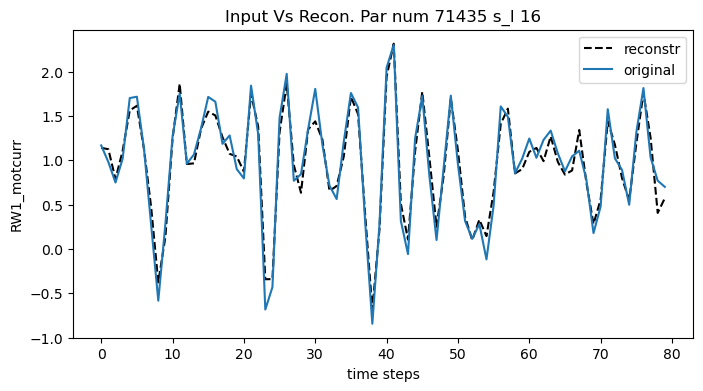

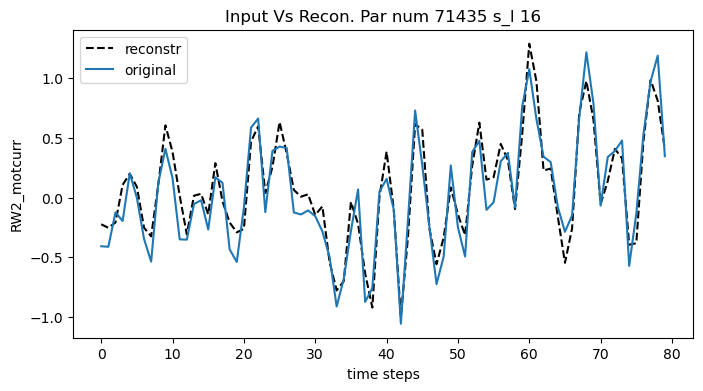

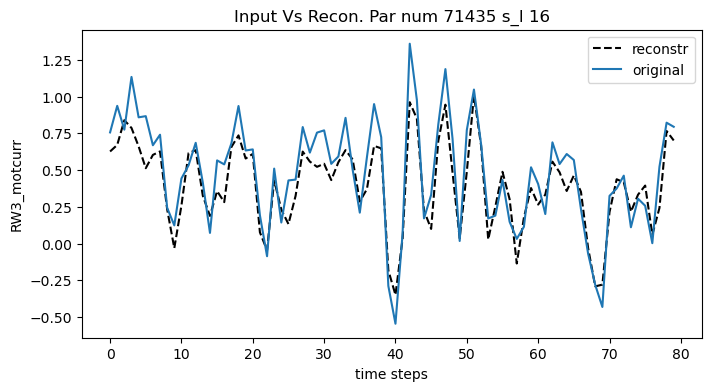

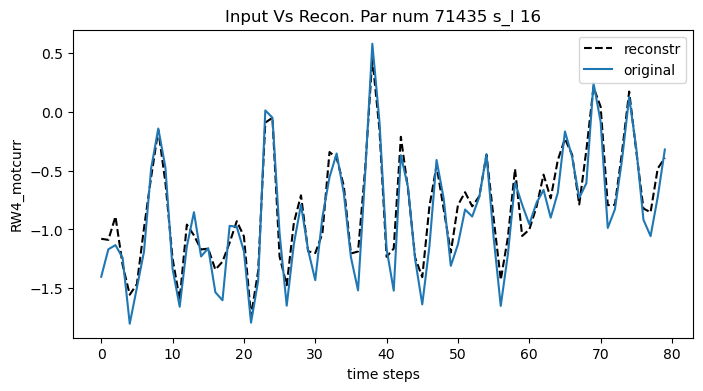

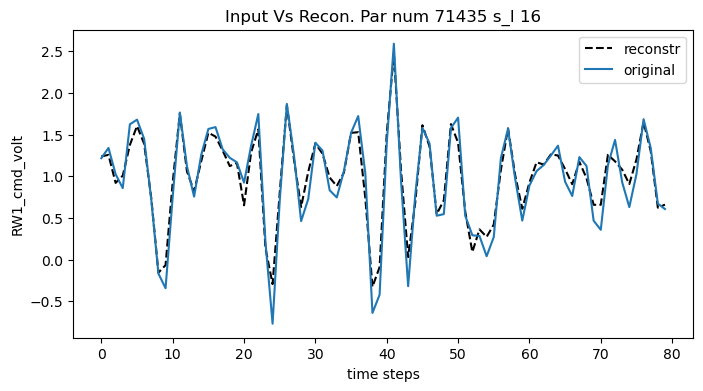

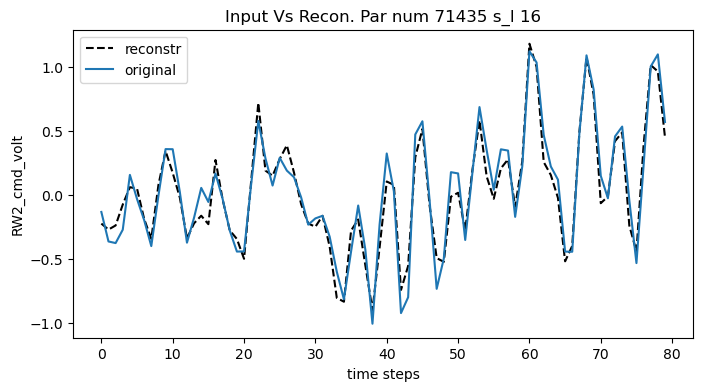

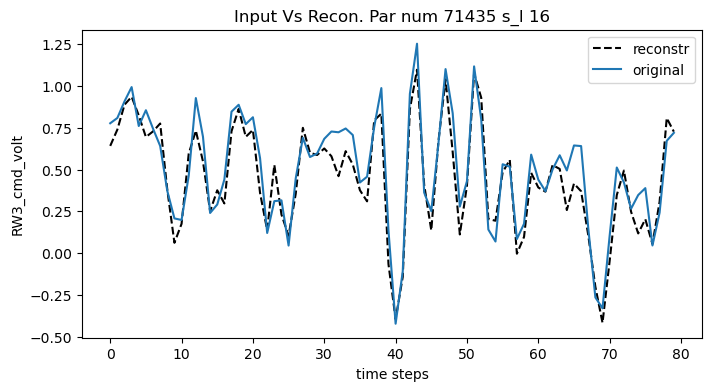

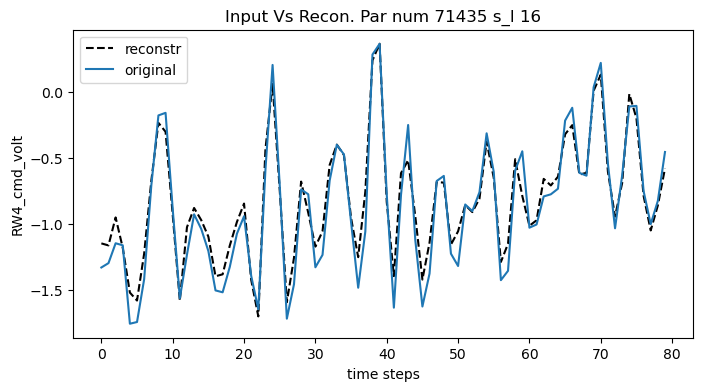

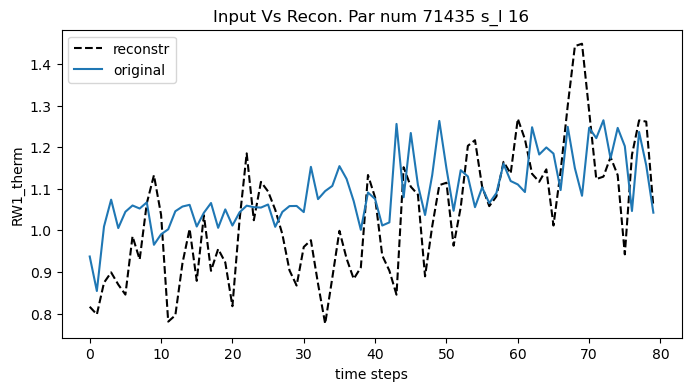

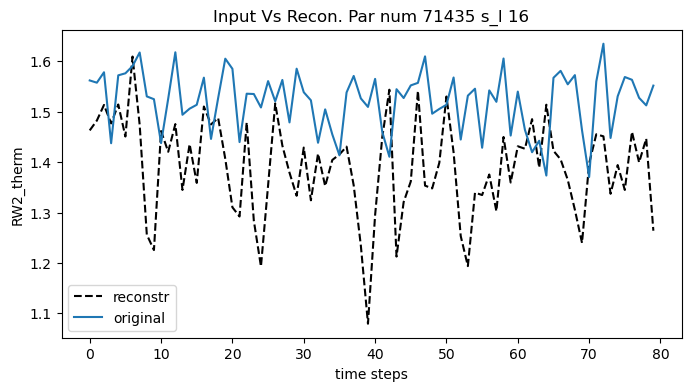

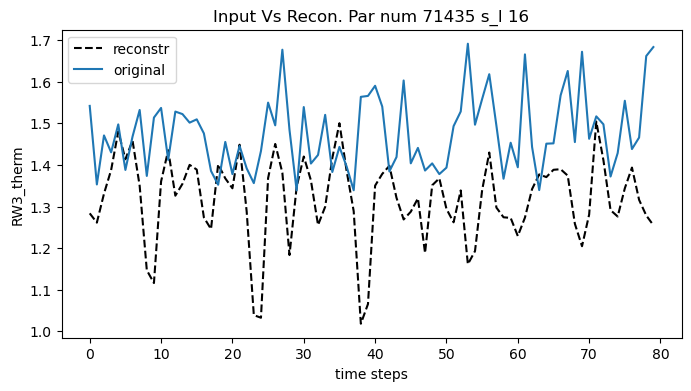

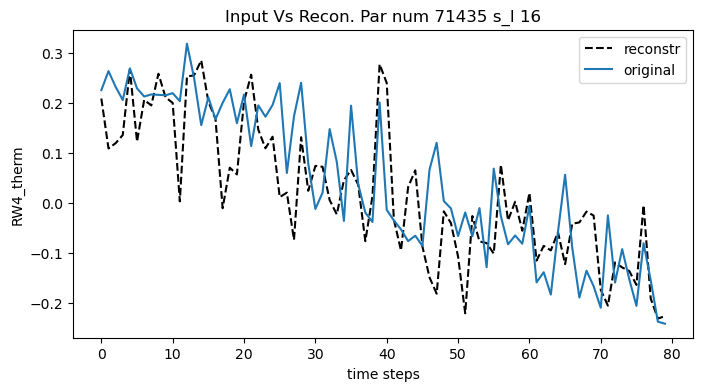

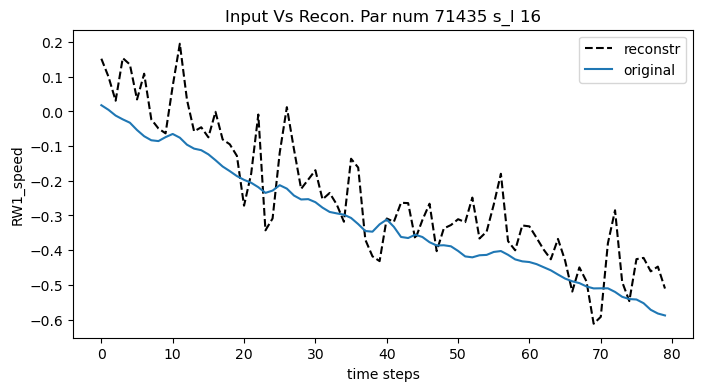

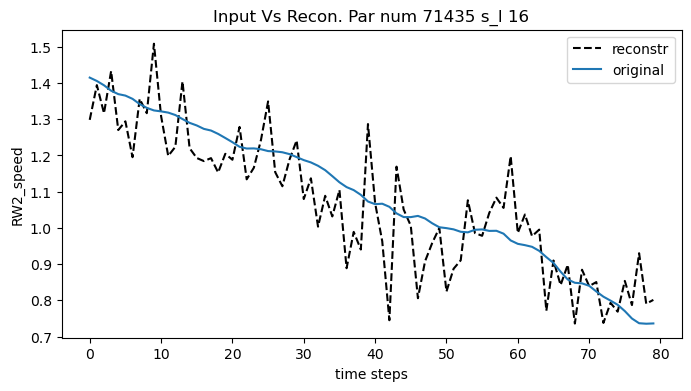

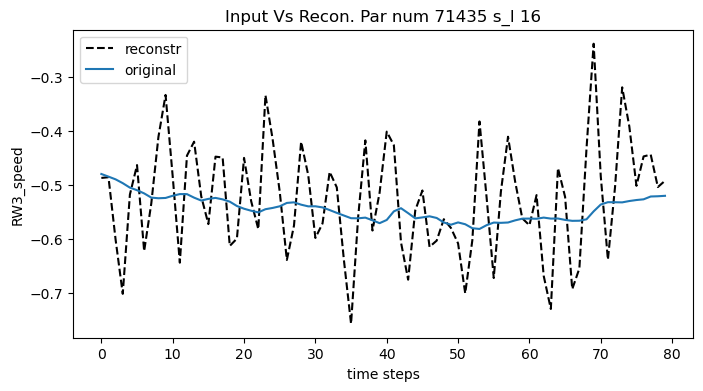

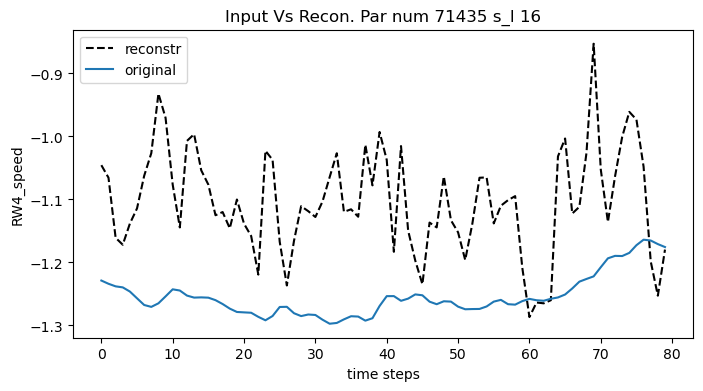

In [46]:
x_plot = x.squeeze().to(device)
show_results(x_plot , yo, cols, model_name, params_conf
     , par_nums, shift, num_batch,arch=architecture,save=False)